# todo когда заработает
Сделай albation study.
- Насколько помогает батчнорм? Что будет если его убрать? Что будет если ставить его не после каждого слоя? Что будет если поменять местами его и ReLU?
- Что будет если меньше данны?
- Что будет если изменить батч сайз?
- Разница между ReLU и LeakyReLU?
- AvgPool vs MaxPool

## Как дебажить

- [x] Прочитай пост Karpathy про то, как тренировать нейронки. Помнишь, ты когда то думал, что ты не практикуешь теоретические знания, поскольку тебе нужна работа для этого? (не тупо learning vs doing трейдофф, а ты именно думал что тебе для раскачивания твоих скиллов как крутого инженера нужно читать теорию, осознанно тестировать на практике, и рефлексировать потом) Вот Karpathy может классные вещи предложить. Визуализировать, логировать распределение градиентов.
- прописать в комментариях размерности для каждого массива на котором оперирую
- Посмотреть, что примеры не смешиваются, прогнав градиентный спуск только на одном тренировочном примере.

In [9]:
import torch
from torch import nn
import numpy as np
from matplotlib import pyplot as plt
import tqdm
import wandb

from data import make_line_image

N_DATAPOINTS = 2000000
HIDDEN_DIM = 32
N_ITERATIONS = 3000
BATCH_SIZE = 64
DIM_MULTIPLIER = 4
BN_MOMENTUM = 0.1

In [10]:
np.random.seed(0)
angles = np.random.uniform(-3, 3, size=N_DATAPOINTS)
images = np.stack([make_line_image(angle) for angle in tqdm.tqdm(angles)])
images = images / 255
images = images.reshape(N_DATAPOINTS, 1, 32, 32)
images = images.astype(np.float32)

100%|██████████| 2000000/2000000 [00:14<00:00, 136607.97it/s]


In [11]:
def get_encoder_block(input_dim, output_dim):
    return nn.Sequential(
        nn.Conv2d(input_dim, output_dim, 3, padding='same'),
        nn.LeakyReLU(0.2),
        nn.BatchNorm2d(output_dim, momentum=BN_MOMENTUM),
        nn.Conv2d(output_dim, output_dim, 3, padding='same'),
        nn.LeakyReLU(0.2),
        nn.BatchNorm2d(output_dim, momentum=BN_MOMENTUM),
        nn.AvgPool2d(2),
    )

def get_encoder():
    encoder = nn.Sequential(
        get_encoder_block(1, 2*DIM_MULTIPLIER),
        get_encoder_block(2*DIM_MULTIPLIER, 4*DIM_MULTIPLIER),
        get_encoder_block(4*DIM_MULTIPLIER, 8*DIM_MULTIPLIER),
        get_encoder_block(8*DIM_MULTIPLIER, 16*DIM_MULTIPLIER),
        nn.Conv2d(16*DIM_MULTIPLIER, 16*DIM_MULTIPLIER, 3, padding='same'),
        nn.LeakyReLU(0.2),
        nn.BatchNorm2d(16*DIM_MULTIPLIER, momentum=BN_MOMENTUM),
        nn.Conv2d(16*DIM_MULTIPLIER, 16*DIM_MULTIPLIER, 3, padding='same'),
    )
    return encoder

In [12]:
def get_decoder_block(input_dim, output_dim):
    return nn.Sequential(
        nn.Conv2d(input_dim, output_dim, 3, padding='same'),
        nn.LeakyReLU(0.2),
        nn.BatchNorm2d(output_dim, momentum=BN_MOMENTUM),
        nn.Conv2d(output_dim, output_dim, 3, padding='same'),
        nn.LeakyReLU(0.2),
        nn.BatchNorm2d(output_dim, momentum=BN_MOMENTUM),
        nn.UpsamplingNearest2d(scale_factor=2),
    )

def get_decoder():
    decoder = nn.Sequential(
        get_decoder_block(16*DIM_MULTIPLIER, 16*DIM_MULTIPLIER),
        get_decoder_block(16*DIM_MULTIPLIER, 8*DIM_MULTIPLIER),
        get_decoder_block(8*DIM_MULTIPLIER, 4*DIM_MULTIPLIER),
        get_decoder_block(4*DIM_MULTIPLIER, 4*DIM_MULTIPLIER),
        nn.Conv2d(4*DIM_MULTIPLIER, 4*DIM_MULTIPLIER, 3, padding='same'),
        nn.LeakyReLU(0.2),
        nn.BatchNorm2d(4*DIM_MULTIPLIER, momentum=BN_MOMENTUM),
        nn.Conv2d(4*DIM_MULTIPLIER, 1, 3, padding='same'),
        nn.Sigmoid(),
    )
    return decoder

In [13]:
def interpolate_encoder(encoder, decoder, idx=0):
    N_STEPS = 9
    image1 = images[idx+0]
    image2 = images[idx+1]

    encoder.eval()
    decoder.eval()
    image1_latent, image2_latent = (encoder(torch.tensor(image).unsqueeze(0)) for image in [image1, image2])
    interpolated_latents = [alpha*image1_latent + (1-alpha)*image2_latent for alpha in np.linspace(0.0, 1.0, N_STEPS)]
    interpolated_images = [decoder(latent).squeeze() for latent in interpolated_latents]

    fig, ax = plt.subplots(1, N_STEPS, figsize=(15, 5))
    for i in range(N_STEPS):
        ax[i].imshow(interpolated_images[i].detach().numpy(), cmap='gray')

In [14]:
def init_weights(module):
    if isinstance(module, nn.Conv2d):
        std = 1 / ((module.in_channels * (1 + 0.2 ** 2)) ** 0.5)
        print(std)
        torch.nn.init.normal_(module.weight, mean=0, std=std)
        module.bias.data.fill_(0.0)

# Autoencoder

In [15]:
encoder = get_encoder()
decoder = get_decoder()

In [98]:
wandb.init(project='acai', name="autoencoder_bn_01__eval_on_50th")

In [99]:
optimizer = torch.optim.Adam([*encoder.parameters(), *decoder.parameters()], lr=0.0001)
encoder.train()
decoder.train()
for iteration in tqdm.tqdm(range(10*N_ITERATIONS)):
    if iteration > 5000:
        encoder.eval()
        decoder.eval()
    batch_indeces = np.random.randint(N_DATAPOINTS, size=BATCH_SIZE)
    batch = images[batch_indeces]
    
    latent_vectors = encoder(torch.tensor(batch))
    reconstructed_images = decoder(latent_vectors)
    loss = torch.nn.functional.mse_loss(torch.tensor(batch), reconstructed_images)
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    
    if iteration % 100 == 0:
        wandb_images = wandb.Image(np.concatenate([
            batch[0].transpose(1, 2, 0),
            reconstructed_images[0].detach().numpy().transpose(1, 2, 0),
        ]))
        wandb.log({"ae": wandb_images, "train/loss": loss.detach().item()})

 43%|████▎     | 12997/30000 [04:07<05:24, 52.46it/s]


KeyboardInterrupt: 

In [ ]:
interpolate_encoder(encoder, decoder)

# ACAI

In [16]:
device = torch.device('cuda')

In [17]:
encoder = get_encoder().to(device)
decoder = get_decoder().to(device)
critic = get_encoder().to(device)

wandb.init(project='acai', name="acai_fix_clean_alpha_computation")

In [ ]:
GAMMA = 0.3
LAMBDA = 0.5
ae_optimizer = torch.optim.Adam([*encoder.parameters(), *decoder.parameters()], lr=0.0001)
critic_optimizer = torch.optim.Adam([*critic.parameters()], lr=0.0001)
encoder.to("cuda")
decoder.to("cuda")

for iteration in tqdm.tqdm(range(2500 * N_ITERATIONS)):
    batch_indeces = np.random.randint(N_DATAPOINTS, size=BATCH_SIZE)
    batch = images[batch_indeces]
    batch = torch.tensor(batch).to(device)
    latent_vectors = encoder(batch)
    reconstructed_images = decoder(latent_vectors)
    
    interpolation_coefficients_batch = torch.tensor(np.random.uniform(0.0, 0.5, size=BATCH_SIZE), dtype=torch.float32).reshape(-1, 1, 1, 1).to(device)
    interpolated_latent_vectors = (
        (1-interpolation_coefficients_batch) * latent_vectors + 
        interpolation_coefficients_batch * torch.cat([latent_vectors[5:], latent_vectors[:5]])
    )
    interpolated_reconstructed_images = decoder(interpolated_latent_vectors)
    predicted_interpolated_alphas = critic(interpolated_reconstructed_images).mean(dim=3).mean(dim=2).mean(dim=1)
    
    if iteration % 2 == 0:
        # critic train step
        predicted_clean_alphas = critic(GAMMA * batch + (1-GAMMA) * reconstructed_images).mean(dim=3).mean(dim=2).mean(dim=1)
        critic_loss = (torch.nn.functional.mse_loss(predicted_interpolated_alphas, interpolation_coefficients_batch.squeeze()) +
                       (predicted_clean_alphas ** 2).mean(dim=0))
        critic_optimizer.zero_grad()
        critic_loss.backward()
        critic_optimizer.step()
        
    else:
        # ae train step
        reconstruction_loss = torch.nn.functional.mse_loss(batch, reconstructed_images)
        adversarial_loss = LAMBDA * (predicted_interpolated_alphas ** 2).mean(dim=0)
        ae_loss = reconstruction_loss + adversarial_loss
        ae_optimizer.zero_grad()
        ae_loss.backward()
        ae_optimizer.step()
    plt.imshow(batch.detach().cpu().numpy()[0].transpose(1, 2, 0), cmap='gray')
    
    if iteration % 4000 == 10:
        wandb_images = wandb.Image(np.concatenate([
            batch.detach().cpu().numpy()[0].transpose(1, 2, 0),
            reconstructed_images[0].detach().cpu().numpy().transpose(1, 2, 0),
        ]))
        wandb.log({
            "ae": wandb_images, 
            "train/ae_loss": ae_loss.detach().item(),
            "train/reconstruction_loss": reconstruction_loss.detach().item(),
            "train/adversarial_loss": adversarial_loss.detach().item(),
            "train/critic_loss": critic_loss.detach().item(),
        })
        # interpolate_encoder(encoder)


  0%|          | 34027/7500000 [06:03<22:59:10, 90.22it/s]

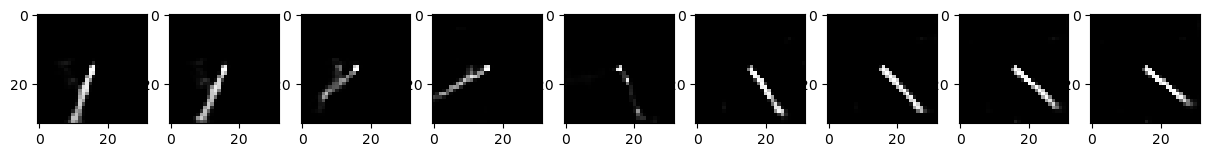

In [21]:
interpolate_encoder(encoder.to("cpu"), decoder.to("cpu"), 5)

In [ ]:
interpolated_image.detach().numpy().round(2)[16:, 16:]

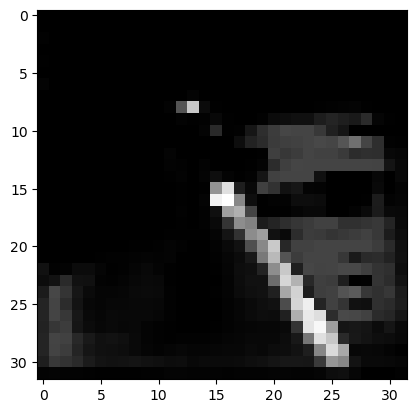

In [121]:
image = images[5]

encoder.eval().cpu()
decoder.eval().cpu()
image_latent = encoder(torch.tensor(image).unsqueeze(0))
interpolated_image = decoder(image_latent).squeeze()

plt.imshow(interpolated_image.detach().numpy(), cmap='gray')